In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
#!pip install imbalanced-learn
#!pip install statsmodels

In [2]:
# load data
aarp = pd.read_csv('Data/clean_AARP.csv')
aarp.head()

,Unnamed: 0,AGE4,INCOME,D6,D8,D9C,D18,D26,MARITAL,EDUC4,...,AGE4_recode,D6_recode,D8_recode,D9C_recode,D18_recode,D26_recode,MARITAL_recode,EDUC4_recode,RACETHNICITY_recode,GENDER_recode
0,0,60+,"$25,000 to $29,999",Good,Everyday,Never,Self-employed part-time,Rural area,Widowed,BA or above,...,4,3,7,1,2,1,2,4,1,1
1,1,60+,"$40,000 to $49,999",Very good,Several times a week,Rarely,Employed full-time,"Suburban with a mix of offices, apartments and...",Widowed,BA or above,...,4,4,6,2,1,2,2,4,1,2
2,2,30-44,"$100,000 to $124,999",Good,Once every 2 or 3 weeks,Sometimes,Unemployed and looking for work,Rural area,Never married,HS graduate or equivalent,...,2,3,4,3,4,1,1,2,1,1
3,3,30-44,"$200,000 or more",Very good,Everyday,Never,Self-employed full-time,"Urban near mix of offices, apartments and shops",Married,HS graduate or equivalent,...,2,4,7,1,1,2,0,2,2,2
4,4,45-59,"$150,000 to $174,999",Good,Several times a week,Never,Employed full-time,Suburban and mostly residential,Married,Some college,...,3,3,6,1,1,2,0,3,1,1


In [3]:
#looks like this isn't in the form we need it to be
aarp.dtypes

Unnamed: 0              int64
AGE4                   object
INCOME                 object
D6                     object
D8                     object
D9C                    object
D18                    object
D26                    object
MARITAL                object
EDUC4                  object
RACETHNICITY           object
GENDER                 object
HHSIZE                  int64
INCOME_recode           int64
AGE4_recode             int64
D6_recode               int64
D8_recode               int64
D9C_recode              int64
D18_recode              int64
D26_recode              int64
MARITAL_recode          int64
EDUC4_recode            int64
RACETHNICITY_recode     int64
GENDER_recode           int64
dtype: object

In [4]:
aarp['MARITAL_recode'].unique()

array([2, 1, 0], dtype=int64)

In [5]:
aarp['D18_recode'].unique()

array([2, 1, 4, 3], dtype=int64)

In [6]:
#found code to fix that

# list vars
model_vars = ['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'D18_recode', 'D26_recode', 'MARITAL_recode', 'EDUC4_recode', 'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode']

# aarp be aarp
aarp = aarp[model_vars]

# recode D9C to binary
# if you never feel SI then 1, else 2, 
# then 0, 1 binary
aarp['is_si'] = aarp['D9C_recode'].apply(lambda x: 1 if x == 1 else 1 if x == 2 else 3)
aarp['is_si'] = aarp['is_si'].apply(lambda x: 0 if x == 1 else 1)

<AxesSubplot:>

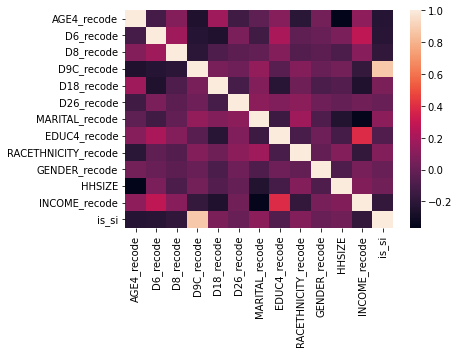

In [7]:
#correlation matrix to prepare for modeling
#D9C was used to make is_si, so thats fine and will be dropped
corr = aarp.corr()
sns.heatmap(corr)

In [8]:
#following Devins lead, recoding nominal variables into dummies
#I believe those are D18 D26 and Marital

aarp = pd.get_dummies(aarp, columns= ['D18_recode', 'D26_recode', 'MARITAL_recode', 'GENDER_recode', 'RACETHNICITY_recode'], prefix= ['D18', 'D26', 'Marital', 'Gender', 'Race'], drop_first= True)
aarp.head()

,AGE4_recode,D6_recode,D8_recode,D9C_recode,EDUC4_recode,HHSIZE,INCOME_recode,is_si,D18_2,D18_3,D18_4,D26_2,Marital_1,Marital_2,Gender_2,Race_2,Race_3,Race_4,Race_5,Race_6
0,4,3,7,1,4,1,6,0,1,0,0,0,0,1,0,0,0,0,0,0
1,4,4,6,2,4,1,9,0,0,0,0,1,0,1,1,0,0,0,0,0
2,2,3,4,3,2,6,14,1,0,0,1,0,1,0,0,0,0,0,0,0
3,2,4,7,1,2,4,18,0,0,0,0,1,0,0,1,1,0,0,0,0
4,3,3,6,1,3,4,16,0,0,0,0,1,0,0,0,0,0,0,0,0


In [9]:
aarp.columns

Index(['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'EDUC4_recode',
       'HHSIZE', 'INCOME_recode', 'is_si', 'D18_2', 'D18_3', 'D18_4', 'D26_2',
       'Marital_1', 'Marital_2', 'Gender_2', 'Race_2', 'Race_3', 'Race_4',
       'Race_5', 'Race_6'],
      dtype='object')

In [10]:
aarp.rename(columns={'D6_recode': 'Health', 'D8_recode': 'Contact', 'D18_2': 'Employed Part Time', 'D18_3':'Retired', 
                    'D18_4':'Unemployed', 'Marital_1':'Never Married', 'Marital_2':'Previously Married', 'D26_2': 'Not Rural', 
                     'AGE4_recode':'Age', 'EDUC4_recode':'Education', 'INCOME_recode': 'Income'}, inplace=True)

In [11]:
aarp.columns

Index(['Age', 'Health', 'Contact', 'D9C_recode', 'Education', 'HHSIZE',
       'Income', 'is_si', 'Employed Part Time', 'Retired', 'Unemployed',
       'Not Rural', 'Never Married', 'Previously Married', 'Gender_2',
       'Race_2', 'Race_3', 'Race_4', 'Race_5', 'Race_6'],
      dtype='object')

In [12]:
#split into x and y for later modeling
x = aarp[['Age', 'Health', 'Contact', 'Education',
       'Race_2', 'Race_3', 'Race_4',
       'Race_5', 'Race_6', 'Gender_2', 'HHSIZE', 'Income',
        'Employed Part Time', 'Retired', 'Unemployed', 'Not Rural', 'Previously Married', 'Never Married']]
y = aarp['is_si']

In [13]:
y.value_counts()

0    1305
1     616
Name: is_si, dtype: int64

In [14]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_x, os_y= os.fit_resample(x_train, y_train)

In [15]:
#it is balanced
os_y.value_counts()

1    926
0    926
Name: is_si, dtype: int64

In [16]:
#insignificant vars are: D8_recode, RACETHNICITY_recode, GENDER_recode, HHSIZE, D18_6, D26_2, Marital_5

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_x)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.604546
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                 1852
Model:                          Logit   Df Residuals:                     1834
Method:                           MLE   Df Model:                           17
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.1278
Time:                        11:50:35   Log-Likelihood:                -1119.6
converged:                       True   LL-Null:                       -1283.7
Covariance Type:            nonrobust   LLR p-value:                 1.670e-59
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.1571      0.063     -2.493      0.013      -0.281      -0.034
Healt

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#accuracy score
sk_logit = LogisticRegression()
sk_logit.fit(os_x, os_y)
y_pred = sk_logit.predict(x_test)

print('Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

Accuracy on test set:0.68


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       379
           1       0.54      0.53      0.53       198

    accuracy                           0.68       577
   macro avg       0.65      0.64      0.64       577
weighted avg       0.68      0.68      0.68       577



In [19]:
for ages in aarp['Age'].unique():
    
    # grab aarp for single age group
    aged_aarp = aarp.loc[aarp['Age'] == ages]
    
    # split into train and test
    aarp_train, aarp_test = train_test_split(aged_aarp, test_size=0.33, random_state=42)
            
    # then create our imbalance object
    from imblearn.over_sampling import SMOTEN
    ab = SMOTEN(random_state=42)
    
    # manually create x,y test and trains
    x_train = aarp_train[['Health', 'Contact', 'Education',
       'Race_2', 'Race_3', 'Race_4',
       'Race_5', 'Race_6', 'Gender_2', 'HHSIZE', 'Income',
        'Employed Part Time', 'Retired', 'Unemployed', 'Not Rural','Never Married', 'Previously Married']]
    x_test = aarp_test[[ 'Health', 'Contact', 'Education',
       'Race_2', 'Race_3', 'Race_4',
       'Race_5', 'Race_6', 'Gender_2', 'HHSIZE', 'Income',
        'Employed Part Time', 'Retired', 'Unemployed', 'Not Rural', 'Never Married', 'Previously Married']]
    y_train = aarp_train['is_si']
    y_test = aarp_test['is_si']
    
    x_train, y_train = ab.fit_resample(x_train, y_train)
    
    # new logistic regression model for p vals
    sk_logit = LogisticRegression()
    
    # let's 'train'
    sk_logit.fit(x_train, y_train)
    
    #import for stats model
    import statsmodels.api as sm
    
    # new logistic regression model for accuracy
    sm_logit = sm.Logit(y_train, x_train)
    result = sm_logit.fit()
    
    #f1 etc
    y_pred = sk_logit.predict(x_test)
    
    # print the results
    print(f'\n---------- score for age {ages}: {round(sk_logit.score(x_test, y_test),3)}% ----------')
    print(result.summary())
    print(classification_report(y_test, y_pred))
        
    ###### print train and test set sizes
    print(f'\ntraining set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 
    
    #Saving summary data to a dataframe for plots
    if ages==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimization terminated successfully.
         Current function value: 0.603608
         Iterations 6

---------- score for age 4: 0.68% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  506
Model:                          Logit   Df Residuals:                      489
Method:                           MLE   Df Model:                           16
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.1292
Time:                        11:50:41   Log-Likelihood:                -305.43
converged:                       True   LL-Null:                       -350.73
Covariance Type:            nonrobust   LLR p-value:                 1.928e-12
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Health                 0.1195      0.114      

C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.530235
         Iterations: 35

---------- score for age 2: 0.629% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  482
Model:                          Logit   Df Residuals:                      465
Method:                           MLE   Df Model:                           16
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.2350
Time:                        11:50:43   Log-Likelihood:                -255.57
converged:                      False   LL-Null:                       -334.10
Covariance Type:            nonrobust   LLR p-value:                 3.164e-25
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Health                -0.3844      0.132     -2.907      0.004      -0.644      -

C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Optimization terminated successfully.
         Current function value: 0.533346
         Iterations 6

---------- score for age 3: 0.646% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  442
Model:                          Logit   Df Residuals:                      425
Method:                           MLE   Df Model:                           16
Date:                Sun, 23 Apr 2023   Pseudo R-squ.:                  0.2305
Time:                        11:50:43   Log-Likelihood:                -235.74
converged:                       True   LL-Null:                       -306.37
Covariance Type:            nonrobust   LLR p-value:                 4.075e-22
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Health                -0.6352      0.139     

In [20]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4

for table in [summary_df1,summary_df2,summary_df3,summary_df4]:
    #Track the index
    index= 0
    
    for row in table['P>|z|']:
        if row <= .1:
            summary_plot.append(table.iloc[index])
        index+=1

In [21]:
summary_df = pd.DataFrame()
for each_df in summary_plot:
    summary_df = pd.concat([summary_df, each_df], axis=1 )
summary_df = summary_df.transpose()
summary_df['Age Group'] = summary_df['Age Group'].astype('int32')

In [22]:
#important vars and their coeffs
summary_df

,coef,std err,z,P>|z|,[0.025,0.975],Age Group
Health,-0.4215,0.126,-3.336,0.001,-0.669,-0.174,1
Never Married,1.4737,0.428,3.445,0.001,0.635,2.312,1
Health,-0.3844,0.132,-2.907,0.004,-0.644,-0.125,2
Contact,-0.1562,0.070,-2.223,0.026,-0.294,-0.018,2
Education,0.9641,0.154,6.280,0.000,0.663,1.265,2
Race_2,-0.9672,0.339,-2.850,0.004,-1.632,-0.302,2
HHSIZE,0.1277,0.074,1.734,0.083,-0.017,0.272,2
Income,-0.2094,0.034,-6.125,0.000,-0.276,-0.142,2
Unemployed,0.7239,0.307,2.358,0.018,0.122,1.326,2
Never Married,0.9976,0.249,4.014,0.000,0.510,1.485,2


[0.3994, 0.164, 1.0501, 0.9862, 0.2073, 1.5137, 1.008, 0.3994] [0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


/var/folders/dl/7fdpm9yx3jj7qxjmtbg0tnwm0000gn/T/ipykernel_5469/4213858417.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(summary_df.index))


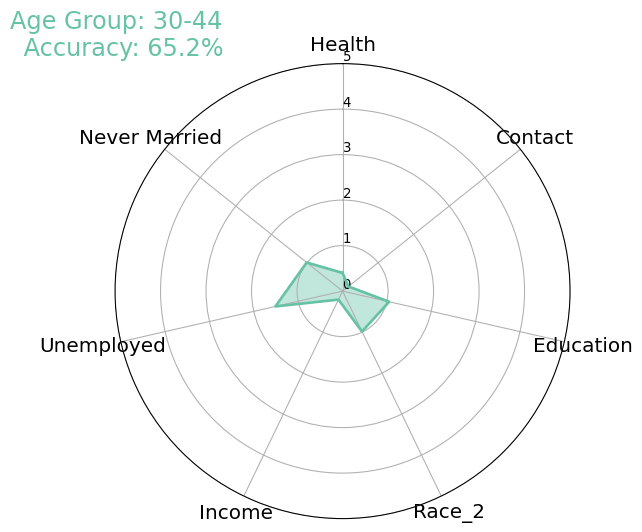

In [49]:
# plotting some radar plots?
# ne

# much courtesy of https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi



# categories are the var names
# only doing one group. Group A
# values is every value under A plus a repeat of the first (so it closes)
 

# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color, df):
    # number of variable
    categories=list(df.index)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(2,2,row, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,1,2,3,4,5], ["0","1","2",'3','4','5'], color="black", size=10)
    plt.ylim(0,5)
    # Ind1
    #values=df.loc[row].drop('group').values.flatten().tolist()
    # values=df.iloc[:,row-1].tolist()
    values = abs(df['coef']).tolist()
    values += values[:1]
    print(f'{values} {angles}')
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=18, color=color, y=1.0,x=0.01)
    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1500/my_dpi, 1300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(summary_df.index))
 
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
    
for row in summary_df['Age Group'].unique():
    title = ''
    if row == 1:
        title = '18-29 \n Accuracy: 63.5%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 2:
        title = '30-44 \n Accuracy: 65.2%'
        make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        break
    if row == 3:
        title = '45-59 \n Accuracy: 61.9%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 4:
        title = '60+ \n Accuracy: 70.9%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
    

# Trying some interactive terms

In [51]:
# regular logit for all age groups
# https://napsterinblue.github.io/notes/machine_learning/regression/interaction_terms/

x = aarp[['Age', 'Health', 'Contact', 'Education',
       'Race_2', 'Race_3', 'Race_4',
       'Race_5', 'Race_6', 'Gender_2', 'HHSIZE', 'Income',
        'Self-employed pt', 'Employed ft', 'Employed pt', 'Retired',
       'Unemployed', 'Unemployed-other', 'Not Rural','Never Married', 'Previously Married']]
y = aarp['is_si']

In [52]:
# rebalancing

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os = SMOTEN(random_state= 42)
x_train, y_train= os.fit_resample(x_train, y_train)

In [53]:
# statsmodels logit

sm_logit = sm.Logit(y_train, x_train)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.601591
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                 1852
Model:                          Logit   Df Residuals:                     1831
Method:                           MLE   Df Model:                           20
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                  0.1321
Time:                        10:39:50   Log-Likelihood:                -1114.1
converged:                       True   LL-Null:                       -1283.7
Covariance Type:            nonrobust   LLR p-value:                 7.722e-60
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.1672      0.064     -2.619      0.009      -0.292      -0.042
Healt

In [54]:
# sklearn logit

sk_logit = LogisticRegression()
sk_logit.fit(x_train, y_train)
y_pred = sk_logit.predict(x_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

Accuracy on test set:0.66


/Users/mattsloan/mambaforge/envs/DTSC/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# let's work on some interactive terms
# how many columns can we expect after adding interactive terms?

print(x.shape)
p = len(x.columns)
expected_columns = (p * (p-1)) / 2 + p + 1
print(f'expected columns: {expected_columns}')

(1921, 21)
expected columns: 232.0


In [56]:
# let's import
from sklearn.preprocessing import PolynomialFeatures

# and let's do the thing

interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# we wanna keep out feature names
from itertools import count
import re

x_to_feature = dict(zip(('x{}'.format(i) for i in count()), x.columns))
feature_keys = list(x_to_feature.keys())[::-1]

features = []

# these two lines were originally below line 30
x_inter = interaction.fit_transform(x)
x_inter_const = sm.add_constant(x_inter)

for feature in interaction.get_feature_names_out():
    for key in feature_keys:
        feature_name = x_to_feature[key]
        feature = re.sub(key, feature_name, feature)
    feature = re.sub(' ', '_', feature)
    features.append(feature)

# these next two lines actually do the column name swapping? is this the right spot?
x_inter = pd.DataFrame(x_inter, columns=features)
x_inter_const = sm.add_constant(x_inter)


x_inter_const.shape
# is this 37 as well? solido

(1921, 232)

(1921, 231)


<Axes: >

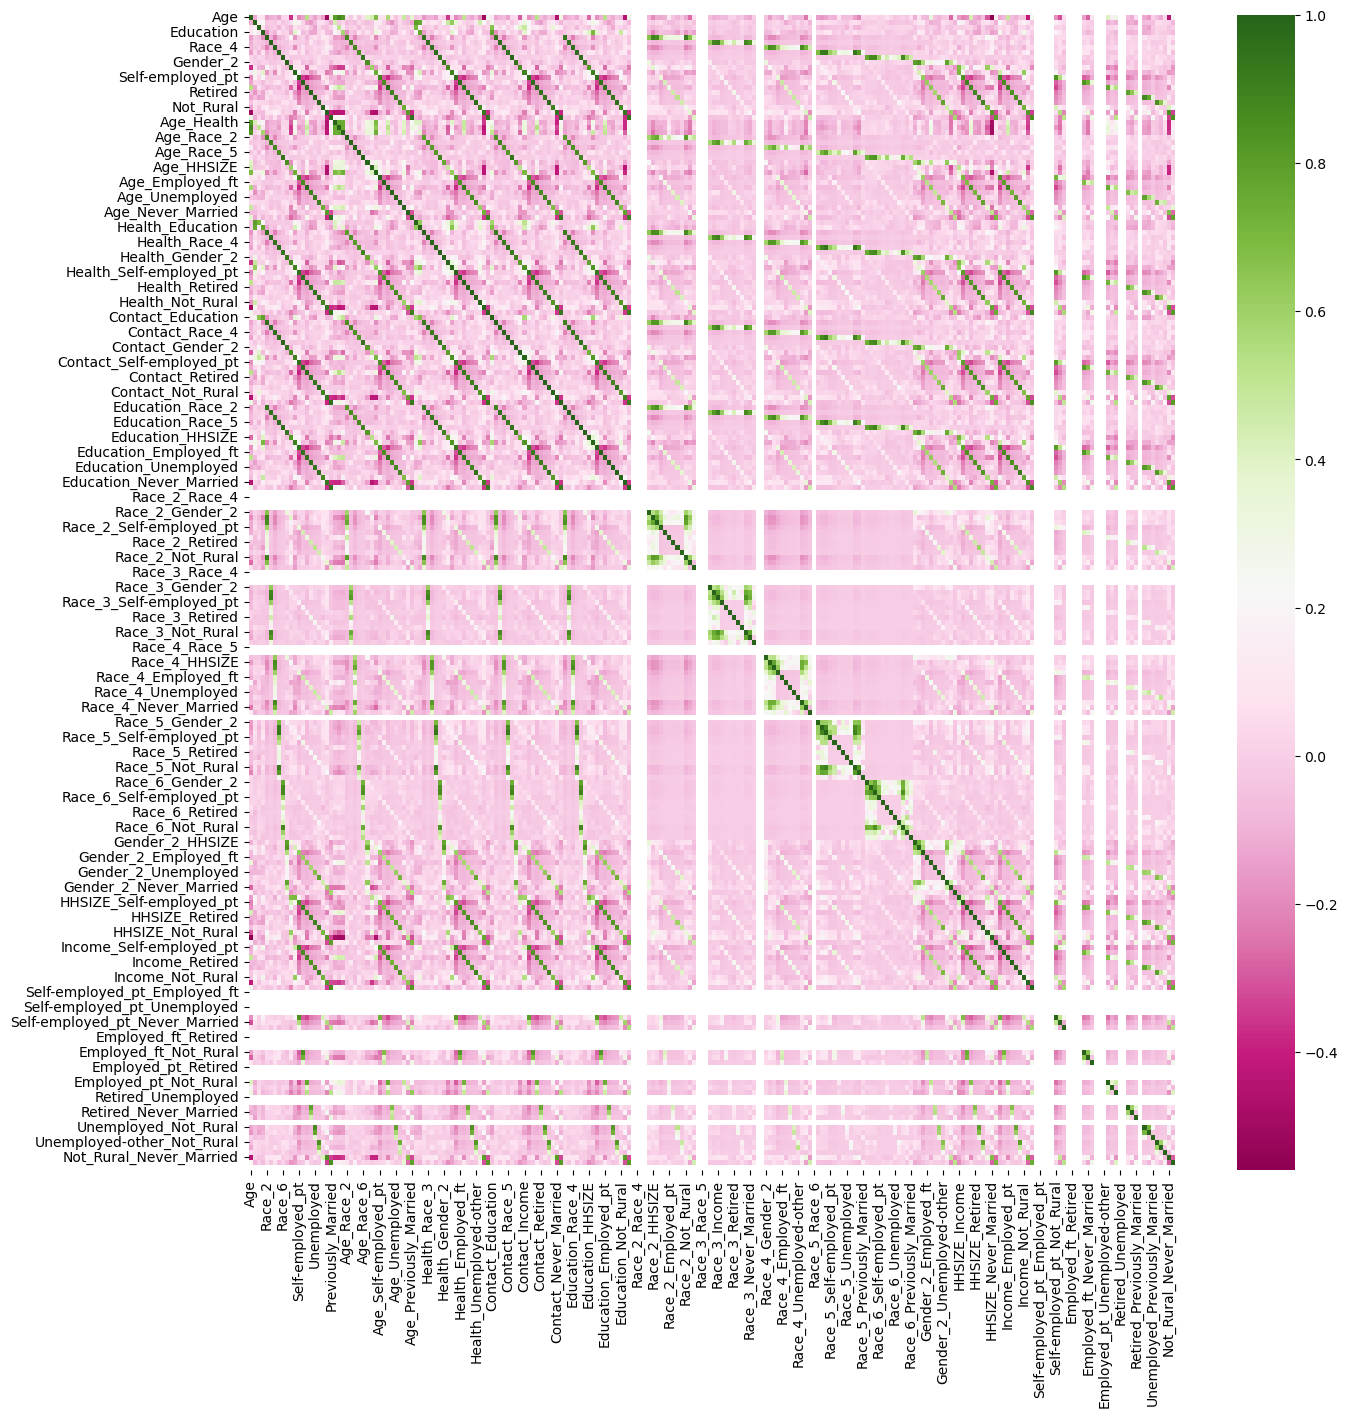

In [57]:
print(x_inter.shape)
plt.figure(figsize=(15,15))
sns.heatmap(x_inter.corr(), cmap="PiYG")

In [64]:
## trying to brute force removal based on significance 

# cutoff = 0.75
# for colm in x_inter.columns:
#     for row in x_inter.columns:
#         if '_' in colm and row != colm and abs(x_inter.corr().at[colm, row]) >= cutoff:
#             x_inter = x_inter.drop(colm, axis=1)
#             break

KeyboardInterrupt: 

In [58]:
for colm in x_inter.columns:
    print(x_inter.corr()[colm])

Age                                    1.000000
Health                                -0.118218
Contact                                0.092511
Education                              0.093750
Race_2                                -0.147357
                                         ...   
Unemployed-other_Never_Married        -0.120843
Unemployed-other_Previously_Married    0.045957
Not_Rural_Never_Married               -0.436984
Not_Rural_Previously_Married           0.222513
Never_Married_Previously_Married            NaN
Name: Age, Length: 231, dtype: float64
Age                                   -0.118218
Health                                 1.000000
Contact                                0.174225
Education                              0.212144
Race_2                                -0.019874
                                         ...   
Unemployed-other_Never_Married         0.050020
Unemployed-other_Previously_Married    0.020981
Not_Rural_Never_Married                0.011175
N

In [92]:
# let's remove multi collinearity
from collinearity import SelectNonCollinear # https://github.com/gianlucamalato/collinearity
from sklearn.feature_selection import f_regression, SelectFdr, chi2
import numpy as np
def rem_collinear_features(correlation_threshold: float, scoring, x_df: pd.DataFrame, y_df: pd.DataFrame):
    selector = SelectNonCollinear(correlation_threshold, scoring=scoring)

    selector.fit(x_df.to_numpy(), y_df.to_numpy())
    mask = selector.get_support() # TODO: read doc on get_support()
    
    return pd.DataFrame(x_df.loc[:,mask],columns = np.array(x_df.columns)[mask]) 

In [93]:
x_inter = rem_collinear_features(0.33, chi2, x_inter, y)

/Users/mattsloan/mambaforge/envs/DTSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mattsloan/mambaforge/envs/DTSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [125]:
# now let us do this again but with interactive terms
# resplit
# rebalance
# re-logit
x_train, x_test, y_train, y_test = train_test_split(x_inter, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os = SMOTEN(random_state = 42)
x_train, y_train= os.fit_resample(x_train, y_train)

# sklearn logit
sk_logit = LogisticRegression()
sk_logit.fit(x_train, y_train)
y_pred = sk_logit.predict(x_test)
print('sklearn Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

# statsmodel logit
sm_logit = sm.Logit(y_train, x_train)
result = sm_logit.fit()
print(f'statsmodels: \n{result.summary()}')

sklearn Accuracy on test set:0.64
         Current function value: 0.516432
         Iterations: 35


/Users/mattsloan/mambaforge/envs/DTSC/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LinAlgError: Singular matrix

# Polynomial interactive terms is not the way (probably)